# Basic Pre-Processing



In [ ]:
!wget http://snap.stanford.edu/data/cit-HepPh.txt.gz -O CitationGraph.txt.gz
!gunzip CitationGraph.txt.gz

--2024-11-15 12:57:28--  http://snap.stanford.edu/data/cit-HepPh.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1664504 (1.6M) [application/x-gzip]
Saving to: ‘CitationGraph.txt.gz’

CitationGraph.txt.g 100%[===================>]   1.59M  3.98MB/s    in 0.4s    

2024-11-15 12:57:28 (3.98 MB/s) - ‘CitationGraph.txt.gz’ saved [1664504/1664504]



In [ ]:
!wget http://snap.stanford.edu/data/cit-HepPh-dates.txt.gz -O CitationDates.txt.gz
!gunzip CitationDates.txt.gz

--2024-11-15 12:57:30--  http://snap.stanford.edu/data/cit-HepPh-dates.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96569 (94K) [application/x-gzip]
Saving to: ‘CitationDates.txt.gz’

CitationDates.txt.g 100%[===================>]  94.31K  --.-KB/s    in 0.08s   

2024-11-15 12:57:30 (1.20 MB/s) - ‘CitationDates.txt.gz’ saved [96569/96569]



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
graph = nx.DiGraph()
reverse_graph = nx.DiGraph()

In [ ]:
# Get basic info about the nodes of the graph

num_edges = 0

max_id = 0
min_id = 1e9

nodes = set()

edge_list = []

with open("CitationGraph.txt", "r") as f:

    lines = f.readlines()
    lines = [line.strip("\n") for line in lines[4:]]

    for line in lines:
        a, b = line.split()
        a = int(a)
        b = int(b)

        max_id = max(max_id, a, b)
        min_id = min(min_id, a, b)

        nodes.add(a)
        nodes.add(b)

        edge_list.append((a, b))

        num_edges += 1

nodes = list(nodes)
nodes.sort()
graph.add_nodes_from(nodes)
reverse_graph.add_nodes_from(nodes)
num_nodes = len(nodes)

for pair in edge_list:
    graph.add_edge(pair[0], pair[1])
    reverse_graph.add_edge(pair[1], pair[0])

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

max_id

Number of nodes: 34546
Number of edges: 421578


9912553

In [ ]:
date_node = []
node_dates = {}

with open("CitationDates.txt", "r") as f:
    lines = f.readlines()
    lines = [line.strip("\n") for line in lines[1:]]

    for line in lines:
        a, b = line.split()
        if(len(a) > 7):
             a = a[2:]
        a = int(a.lstrip('0'))
        if not graph.has_node(a):
            if str(a)[:2] == "11":
                a = int(str(a)[2:])
            if not graph.has_node(a):
                continue
        # date_node.append((b, a))
        if(node_dates.get(a) == None):
            node_dates[a] = b
        else:
            node_dates[a] = min(node_dates[a], b)

for node in node_dates:
    date_node.append((node_dates[node], node))

# for node in graph.nodes():              # If the date of a particular paper is not in the file, we set the date to be something greater than the latest paper
#     if node_dates.get(node) == None:
#         node_dates[node] = "2002-04-01"
#         date_node.append((node_dates[node], node))

date_node.sort()
print(len(date_node))
cnt = 0


30561


In [ ]:
print(date_node[0][0], date_node[-1][0])

1992-02-11 2002-04-01


In [ ]:
def lower_bound(date):
    l = 0
    r = len(date_node)

    while l != r:
        mid = int((l+r)/2)
        if(date_node[mid][0] >= date):
            r = mid
        else:
            l = mid + 1
    return l


In [ ]:
time_graph = nx.DiGraph()
time_reverse_graph = nx.DiGraph()

def add_edges(start_date, end_date):
    start_idx = lower_bound(start_date)

    for i in range(start_idx, len(date_node)):
        if(date_node[i][0] > end_date):
            break
        # print(start_date, end_date, )
        node = date_node[i][1]
        time_graph.add_node(node)
        time_reverse_graph.add_node(node)
        for e in graph.neighbors(node):
            if time_graph.has_node(e):
                time_graph.add_edge(node, e)
                time_reverse_graph.add_edge(e, node)

        for e in reverse_graph.neighbors(node):
            if time_graph.has_node(e):
                time_graph.add_edge(e, node)
                time_reverse_graph.add_edge(node, e)

def add_bidirectional_edges(start_date, end_date):
    start_idx = lower_bound(start_date)

    for i in range(start_idx, len(date_node)):
        if(date_node[i][0] > end_date):
            break
        # print(start_date, end_date, )
        node = date_node[i][1]
        time_graph.add_node(node)
        time_reverse_graph.add_node(node)
        for e in graph.neighbors(node):
            if time_graph.has_node(e):
                time_graph.add_edge(node, e)

        for e in reverse_graph.neighbors(node):
            if time_graph.has_node(e):
                time_graph.add_edge(e, node)


# Analysing the Graph

## Indegree of the nodes

### Average indegrees of nodes classified by time intervals over a period of time

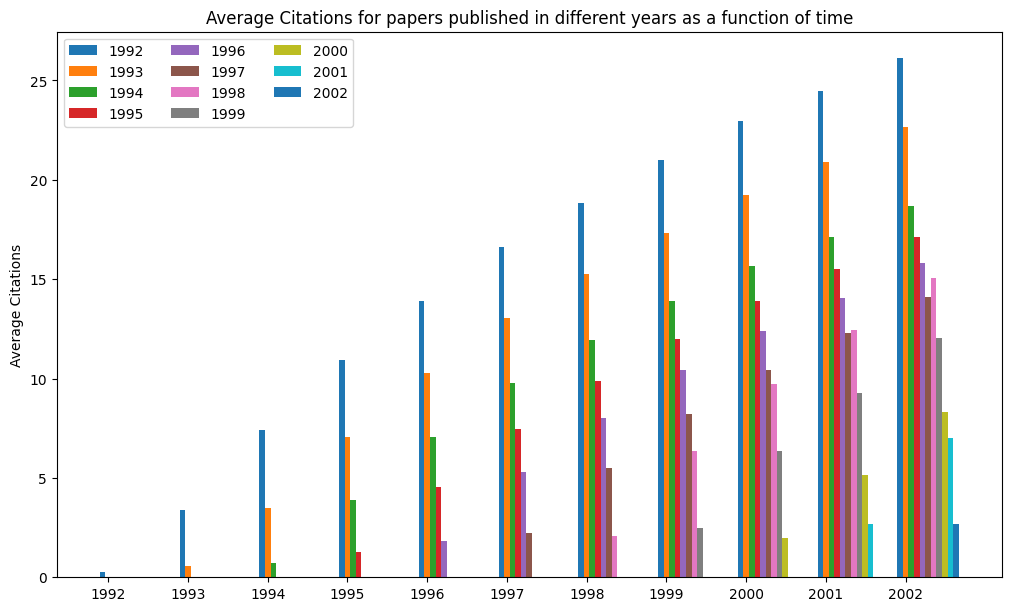

In [ ]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

time_graph = nx.DiGraph()
time_reverse_graph = nx.DiGraph()

published_year = tuple(str(year) for year in range(1992, 2003))
data_points = {year:[0 for _ in range(11)] for year in published_year}

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    tot = [0 for _ in range(11)]
    cnt = [0 for _ in range(11)]

    for node in time_graph.nodes:
        tot[int(node_dates[node][:4]) - 1992] += time_graph.in_degree(node)
        cnt[int(node_dates[node][:4]) - 1992] += 1

    for j in range(11):
        if tot[j] > 0:
            data_points[str(j+1992)][i-1992] = tot[j]/cnt[j]

# print(data_points)

x = np.arange(len(published_year))  # the label locations
width = 0.07  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,6))

for attribute, measurement in data_points.items():
    offset = width * multiplier
    # print(measurement)
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Citations')
ax.set_title('Average Citations for papers published in different years as a function of time')
ax.set_xticks(x + width, published_year)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim()

plt.show()

As expected, the average citations of the papers released in a particular year increases over time. And not very surprisingly, the papers released earlier tend to have more average citations.

There could be two major reason why the average citations are greater.

(i)  These papers are more fundamental

(ii) The higher number of citation is only due to the papers being around for a longer period of time

To test these possibilities out, we can correct for the number of years the paper has been out by dividing the computed average by it.

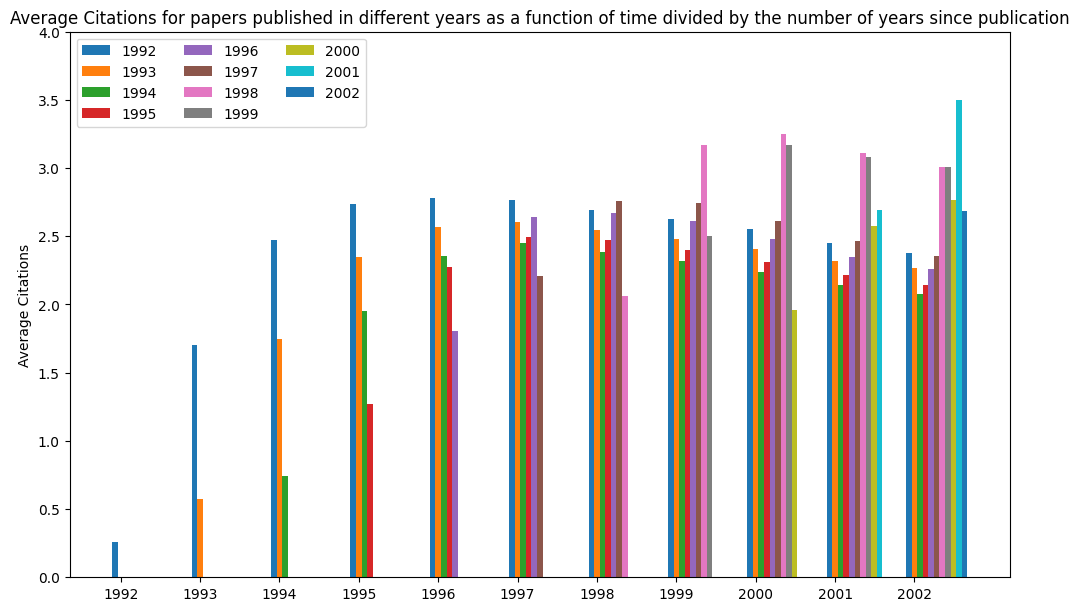

In [ ]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

time_graph = nx.DiGraph()
time_reverse_graph = nx.DiGraph()

published_year = tuple(str(year) for year in range(1992, 2003))
data_points = {year:[0 for _ in range(11)] for year in published_year}

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    tot = [0 for _ in range(11)]
    cnt = [0 for _ in range(11)]

    for node in time_graph.nodes:
        tot[int(node_dates[node][:4]) - 1992] += time_graph.in_degree(node)
        cnt[int(node_dates[node][:4]) - 1992] += 1

    for j in range(11):
        if tot[j] > 0:
            data_points[str(j+1992)][i-1992] = (tot[j]/cnt[j])/(i - 1992 - j + 1)

# print(data_points)

x = np.arange(len(published_year))  # the label locations
width = 0.07  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,6))

for attribute, measurement in data_points.items():
    offset = width * multiplier
    # print(measurement)
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Citations')
ax.set_title('Average Citations for papers published in different years as a function of time divided by the number of years since publication')
ax.set_xticks(x + width, published_year)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 4)

plt.show()

This normalized graph showcases that possibility (ii) is the most prevelant reason as to why a paper might be sighted more often.

Though newly released papers have lower number of citations when they first come out, they eventually catch up to have around the same average number of citations as any older paper.

Another graph that would be interesting to look at would be the average citations of papers `x` years since release.

Text(0.5, 0, 'Years since publication')

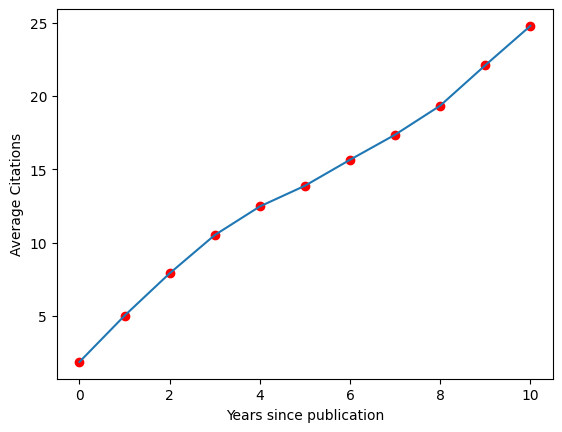

In [ ]:
time_graph = nx.DiGraph()
time_reverse_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i for i in range(11)]

tot = [0 for _ in range(11)]
cnt = [0 for _ in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')

    for node in time_graph.nodes:
        tot[i - int(node_dates[node][:4])] += time_graph.in_degree(node)
        cnt[i - int(node_dates[node][:4])] += 1

for j in range(11):
    if tot[j] > 0:
        y_val[j] = tot[j]/cnt[j]

plt.plot(x_val, y_val, 'ro', x_val, y_val)
plt.ylabel("Average Citations")
plt.xlabel("Years since publication")

As expected the papers have a gradually increasing average publication. The rate of increase seems almost linear.

## Components of the Graph

### Connected components
Here we can treat the edges to be bidirectional and analyse the graph connectivity.

[Text(0, 0, '582'),
 Text(0, 0, '2,117'),
 Text(0, 0, '4,421'),
 Text(0, 0, '7,276'),
 Text(0, 0, '10,481'),
 Text(0, 0, '14,013'),
 Text(0, 0, '17,736'),
 Text(0, 0, '21,739'),
 Text(0, 0, '25,893'),
 Text(0, 0, '29,878'),
 Text(0, 0, '30,561')]

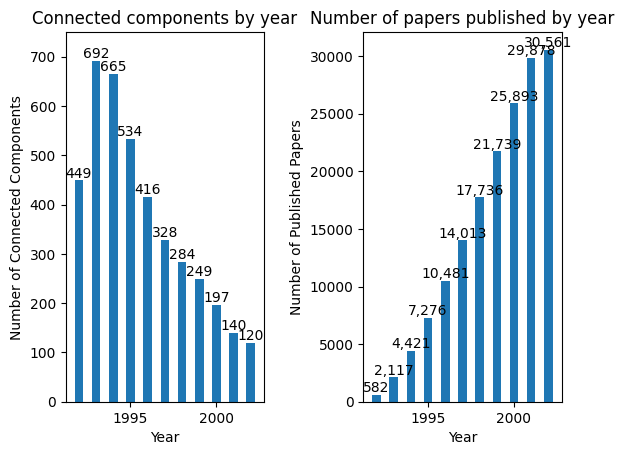

In [ ]:
time_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i + 1992 for i in range(11)]
y_val2 = [0 for _ in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    y_val[i - 1992] = nx.number_weakly_connected_components(time_graph)
    y_val2[i - 1992] = time_graph.number_of_nodes()

fig, axs = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
ax = axs[0]
bar_container = ax.bar(x_val, y_val, width=0.5)
ax.set(xlabel='Year', ylabel='Number of Connected Components', title='Connected components by year', ylim=(0, 750))
ax.bar_label(bar_container, fmt='{:,.0f}')

ax = axs[1]
bar_container = ax.bar(x_val, y_val2, width=0.5)
ax.set(xlabel='Year', ylabel='Number of Published Papers', title='Number of papers published by year')
ax.bar_label(bar_container, fmt='{:,.0f}')



The number of connected components is low in the year 1992 and quckly rises to its peak in 1993 and gradually falls down.

1993 is the sweetspot where there are enough papers to form many different connected components but not enough to have a lot of these components connected to each other.

The density of the graph might give us more insight into the connected components plot's shape.

0.0004487429293466067
0.0006385985283673186
0.0005821877560885537
0.0005630506404058801
0.0005364248513953322
0.0005006361420244647
0.0004543852105221289
0.00042595591145560305
0.00039530615023639234
0.00037420512426729666
0.00035325018813313786


[Text(0, 0, '0.00045'),
 Text(0, 0, '0.00064'),
 Text(0, 0, '0.00058'),
 Text(0, 0, '0.00056'),
 Text(0, 0, '0.00054'),
 Text(0, 0, '0.00050'),
 Text(0, 0, '0.00045'),
 Text(0, 0, '0.00043'),
 Text(0, 0, '0.00040'),
 Text(0, 0, '0.00037'),
 Text(0, 0, '0.00035')]

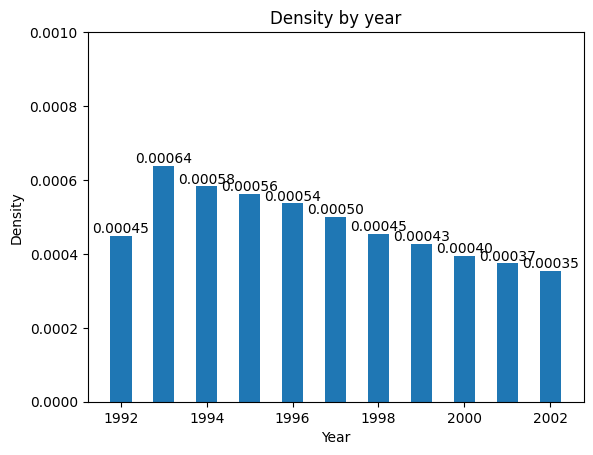

In [ ]:
time_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i + 1992 for i in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')

    y_val[i-1992] = time_graph.number_of_edges() / (time_graph.number_of_nodes() * (time_graph.number_of_nodes() - 1))
    print(time_graph.number_of_edges() / (time_graph.number_of_nodes() ** 2))

fig, ax = plt.subplots()
bar_container = ax.bar(x_val, y_val, width=0.5)
ax.set(xlabel='Year', ylabel='Density', title='Density by year', ylim=(0, 0.001))
ax.bar_label(bar_container, fmt='{:,.5f}')

I was moderately surprised by this plot. In the plot, the density of the graph in 1993 is the highest. Considering the high number of connected components in the year 1993, I expected the graph to have a lower density.

The reason behind this could possibly be because in the year 1993, there are few dense subgraphs with many edges which largely contribute to the average while there are a lot of other very small subgraphs which increase the total number of connected components.

We can try to analyze the connected components of the graph in 1993.

In [ ]:
time_graph = nx.DiGraph()
add_edges('1992-01-01', '1993-12-31')

prop = []

for comp in nx.weakly_connected_components(time_graph):
    subgraph = time_graph.subgraph(comp)
    prop.append((subgraph.number_of_edges(), subgraph.number_of_nodes()))

prop.sort(reverse=True)

print("Total Nodes:", time_graph.number_of_nodes())
print("Total Edges:", time_graph.number_of_edges())
print()

for i in range(10):
    print("Number of Edges:", prop[i][0])
    print("Number of Nodes:", prop[i][1]);
    print("Density:", prop[i][0]/(prop[i][1]*(prop[i][1] - 1)))
    print("*"*50)

Total Nodes: 2117
Total Edges: 2862

Number of Edges: 2717
Number of Nodes: 1293
Density: 0.0016264046221736955
**************************************************
Number of Edges: 17
Number of Nodes: 13
Density: 0.10897435897435898
**************************************************
Number of Edges: 6
Number of Nodes: 5
Density: 0.3
**************************************************
Number of Edges: 5
Number of Nodes: 5
Density: 0.25
**************************************************
Number of Edges: 5
Number of Nodes: 5
Density: 0.25
**************************************************
Number of Edges: 4
Number of Nodes: 5
Density: 0.2
**************************************************
Number of Edges: 4
Number of Nodes: 5
Density: 0.2
**************************************************
Number of Edges: 4
Number of Nodes: 5
Density: 0.2
**************************************************
Number of Edges: 4
Number of Nodes: 4
Density: 0.3333333333333333
*************************************

Yay :). Our hypothesis about a few components containing most of the edges seems correct. Infact there is a single component which contains a majority of the edges of the graph.

To further confirm this, we will try to contrast this with the graph in the year 2002.

In [ ]:
time_graph = nx.DiGraph()
add_edges('1992-01-01', '2002-12-31')

prop = []

for comp in nx.weakly_connected_components(time_graph):
    subgraph = time_graph.subgraph(comp)
    prop.append((subgraph.number_of_edges(), subgraph.number_of_nodes()))

prop.sort(reverse=True)

print("Total Nodes:", time_graph.number_of_nodes())
print("Total Edges:", time_graph.number_of_edges())
print()

for i in range(10):
    print("Number of Edges:", prop[i][0])
    print("Number of Nodes:", prop[i][1]);
    print("Density:", prop[i][0]/(prop[i][1]*(prop[i][1] - 1)))
    print("*"*50)

Total Nodes: 34546
Total Edges: 421578

Number of Edges: 421485
Number of Nodes: 34401
Density: 0.0003561661268635376
**************************************************
Number of Edges: 8
Number of Nodes: 6
Density: 0.26666666666666666
**************************************************
Number of Edges: 6
Number of Nodes: 5
Density: 0.3
**************************************************
Number of Edges: 5
Number of Nodes: 5
Density: 0.25
**************************************************
Number of Edges: 4
Number of Nodes: 5
Density: 0.2
**************************************************
Number of Edges: 4
Number of Nodes: 4
Density: 0.3333333333333333
**************************************************
Number of Edges: 3
Number of Nodes: 4
Density: 0.25
**************************************************
Number of Edges: 3
Number of Nodes: 3
Density: 0.5
**************************************************
Number of Edges: 2
Number of Nodes: 3
Density: 0.3333333333333333
******************

A similar structure seems to hold with the graph here too. There is a single component containing a lot of the edges.

Though it seems like there isn't a clear contrast between the graph in 1993 and 2002, the ratio of the nodes in the largest connected component to the total number of nodes is very different.

In the graph formed in the year 2002, a large fraction of the nodes are in the largest component. Whereas in the 1993 graph, a relatively smaller portion is in the largest component. The remaining nodes form a lot more smaller components.

Next, I thought it would be interesting to look at the plot of the number of edges and nodes in the largest connected component over different years.

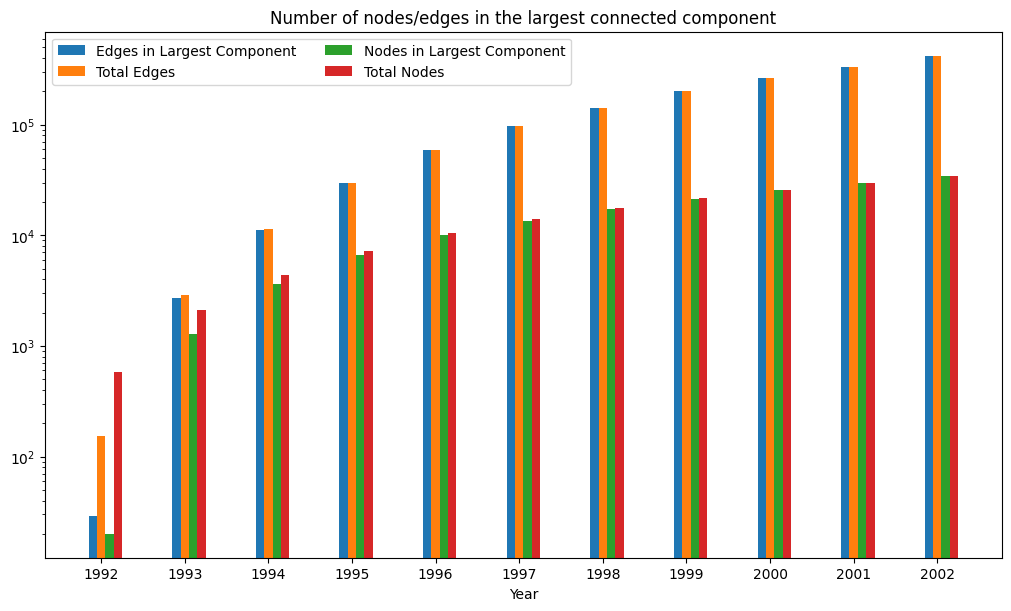

In [ ]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

time_graph = nx.DiGraph()
time_reverse_graph = nx.DiGraph()

published_year = tuple(str(year) for year in range(1992, 2003))
data_points = {"Edges in Largest Component": [0 for _ in range(11)],
               "Total Edges": [0 for _ in range(11)],
               "Nodes in Largest Component": [0 for _ in range(11)],
               "Total Nodes": [0 for _ in range(11)]}

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')

    component = max(nx.weakly_connected_components(time_graph), key=len)
    subgraph = time_graph.subgraph(component)

    data_points["Edges in Largest Component"][i-1992] = subgraph.number_of_edges()
    data_points["Nodes in Largest Component"][i-1992] = subgraph.number_of_nodes()
    data_points["Total Edges"][i-1992] = time_graph.number_of_edges()
    data_points["Total Nodes"][i-1992] = time_graph.number_of_nodes()

# print(data_points)

x = np.arange(len(published_year))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,6))

for attribute, measurement in data_points.items():
    offset = width * multiplier
    # print(measurement)
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.yscale("log")
ax.set_xlabel('Year')
ax.set_title('Number of nodes/edges in the largest connected component')
ax.set_xticks(x + width, published_year)
ax.legend(loc='upper left', ncols=2)
# ax.set_ylim(0, 40000)


plt.show()

In the later years, the number of nodes/edges in the largest connected component is almost equal to the total number of nodes/edges. This makes it clear why the number of connected components is lower there.

[Text(0, 0, '3.44'),
 Text(0, 0, '61.08'),
 Text(0, 0, '81.81'),
 Text(0, 0, '90.87'),
 Text(0, 0, '95.25'),
 Text(0, 0, '97.10'),
 Text(0, 0, '97.87'),
 Text(0, 0, '98.45'),
 Text(0, 0, '98.93'),
 Text(0, 0, '99.26'),
 Text(0, 0, '99.58')]

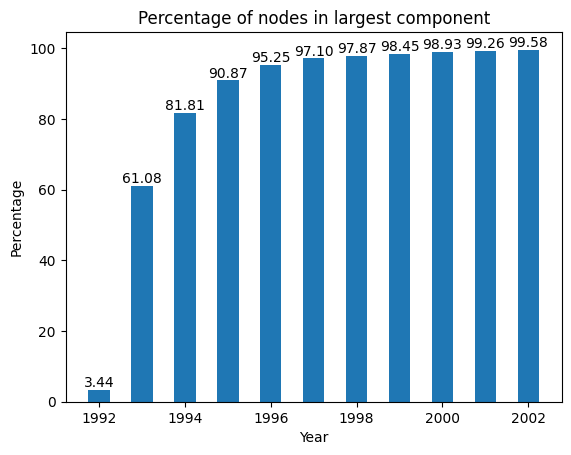

In [ ]:
time_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i + 1992 for i in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')

    y_val[i-1992] = len(max(nx.weakly_connected_components(time_graph), key=len)) / time_graph.number_of_nodes() * 100
    # print(time_graph.number_of_edges() / (time_graph.number_of_nodes() ** 2))

fig, ax = plt.subplots()
bar_container = ax.bar(x_val, y_val, width=0.5)
ax.set(xlabel='Year', ylabel='Percentage', title='Percentage of nodes in largest component')
ax.bar_label(bar_container, fmt='{:,.2f}')

[Text(0, 0, '562'),
 Text(0, 0, '824'),
 Text(0, 0, '804'),
 Text(0, 0, '664'),
 Text(0, 0, '498'),
 Text(0, 0, '406'),
 Text(0, 0, '378'),
 Text(0, 0, '338'),
 Text(0, 0, '276'),
 Text(0, 0, '222'),
 Text(0, 0, '145')]

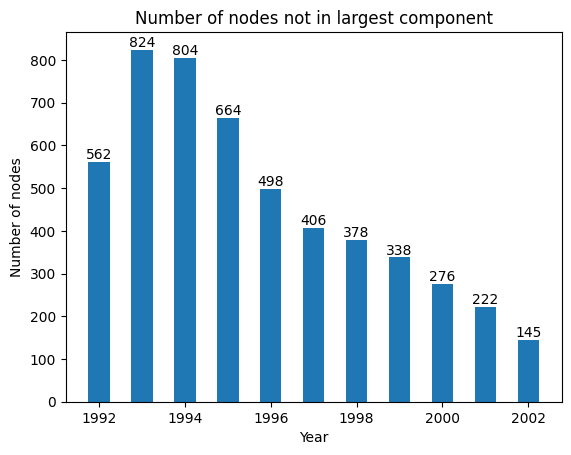

In [ ]:
time_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i + 1992 for i in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')

    y_val[i-1992] = time_graph.number_of_nodes() - len(max(nx.weakly_connected_components(time_graph), key=len))
    # print(time_graph.number_of_edges() / (time_graph.number_of_nodes() ** 2))

fig, ax = plt.subplots()
bar_container = ax.bar(x_val, y_val, width=0.5)
ax.set(xlabel='Year', ylabel='Number of nodes', title='Number of nodes not in largest component')
ax.bar_label(bar_container)

Next we'll try to look at the Strongly Connected Components in the graph.

The fact that SCCs exist initally surprised me. For an SCC to exist a cycle in the graph should exist. If we go with the assumption that a paper can only cite a paper released before it, a cycle cannot exist.

The reason cycles exist is because the assumption that papers can only cite past papers is false. Looking at multiple dates for some papers, it was clear that different versions of papers may be published on different dates. And in a future version a paper can cite a paper which was published after its inital release (which could have potentialy cited this paper)

[Text(0, 0, '582'),
 Text(0, 0, '2,114'),
 Text(0, 0, '4,413'),
 Text(0, 0, '7,263'),
 Text(0, 0, '10,459'),
 Text(0, 0, '13,964'),
 Text(0, 0, '17,622'),
 Text(0, 0, '20,553'),
 Text(0, 0, '23,795'),
 Text(0, 0, '24,731'),
 Text(0, 0, '21,608')]

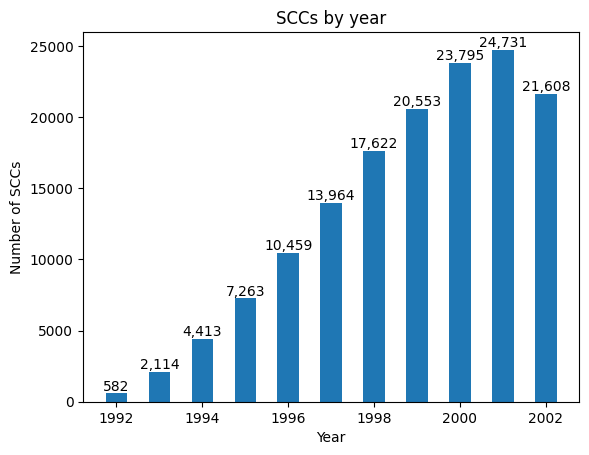

In [ ]:
time_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i + 1992 for i in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    y_val[i - 1992] = nx.number_strongly_connected_components(time_graph)

fig, ax = plt.subplots()
plt.subplots_adjust(wspace=0.5)
bar_container = ax.bar(x_val, y_val, width=0.5)
ax.set(xlabel='Year', ylabel='Number of SCCs', title='SCCs by year')
ax.bar_label(bar_container, fmt='{:,.0f}')



[Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '9'),
 Text(0, 0, '21'),
 Text(0, 0, '699'),
 Text(0, 0, '1,079'),
 Text(0, 0, '2,993'),
 Text(0, 0, '12,711')]

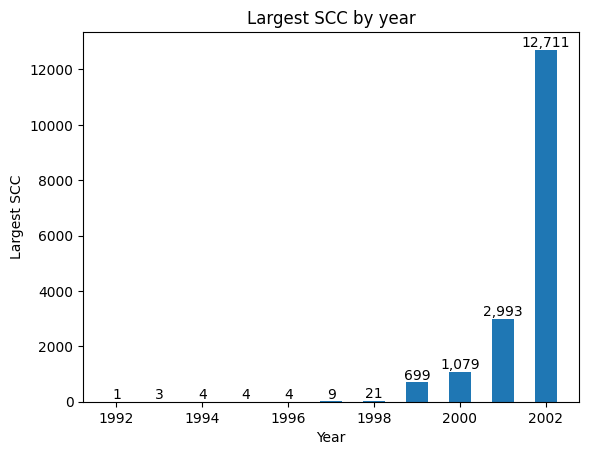

In [ ]:
time_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i + 1992 for i in range(11)]
y_val2 = [0 for _ in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    y_val[i - 1992] = len(max(nx.strongly_connected_components(time_graph), key=len))

fig, ax = plt.subplots()
plt.subplots_adjust(wspace=0.5)
bar_container = ax.bar(x_val, y_val, width=0.5)
ax.set(xlabel='Year', ylabel='Largest SCC', title='Largest SCC by year')
ax.bar_label(bar_container, fmt='{:,.0f}')

## Analyzing distances in the Graph

Eccentricity of the nodes of the graph is one property from which a lot of interesting information about the graph can be gathered.

Since the eccentricity of nodes for unconnected graphs isn't clearly defined.

1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002


Text(0.5, 0, 'Year')

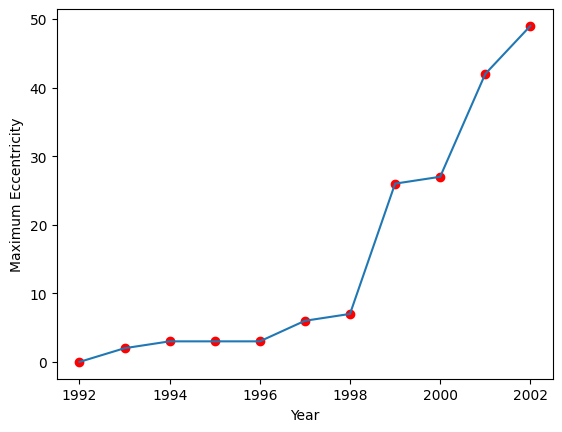

In [ ]:
time_graph = nx.DiGraph()
time_reverse_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i+1992 for i in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    print(i)

    comp = max(nx.strongly_connected_components(time_graph), key=len)
    subgraph = time_graph.subgraph(comp)
    y_val[i - 1992] = max(y_val[i-1992], *nx.eccentricity(subgraph).values())
plt.plot(x_val, y_val, 'ro', x_val, y_val)
plt.ylabel("Maximum Eccentricity")
plt.xlabel("Year")

1999
2000
2001
2002


Text(0.5, 0, 'Year')

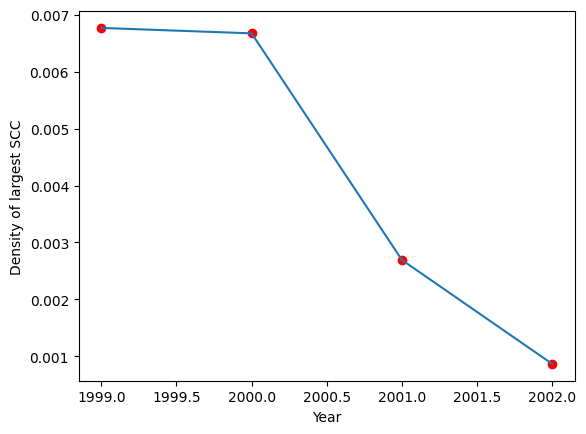

In [ ]:
time_graph = nx.DiGraph()
time_reverse_graph = nx.DiGraph()

y_val = [0 for _ in range(4)]
x_val = [i+1999 for i in range(4)]

add_edges('1992-01-01', '1998-12-31')

for i in range(1999, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    print(i)

    comp = max(nx.strongly_connected_components(time_graph), key=len)
    subgraph = time_graph.subgraph(comp)
    if subgraph.number_of_nodes() > 1:
        y_val[i - 1999] = subgraph.number_of_edges() / (subgraph.number_of_nodes() * (subgraph.number_of_nodes() - 1))
plt.plot(x_val, y_val, 'ro', x_val, y_val)
plt.ylabel("Density of largest SCC")
plt.xlabel("Year")

## Days between cited papers

The number of days between the first version of the cited paper and the paper citing it.

In [ ]:
import time


def days_between_dates(dt1, dt2):

    date_format = "%Y-%m-%d"
    a = time.mktime(time.strptime(dt1, date_format))
    b = time.mktime(time.strptime(dt2, date_format))
    delta = b - a
    return int(delta / 86400)


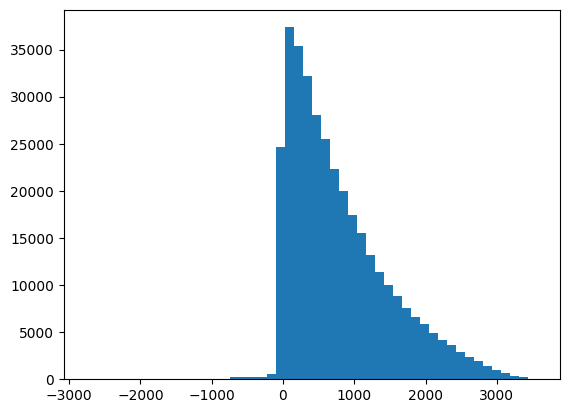

In [ ]:
L = []
for node in graph.nodes():
    for neigh in graph.successors(node):
        if neigh in node_dates and node in node_dates:
            L.append(days_between_dates(node_dates[neigh], node_dates[node]))

n_bins = 50
counts, bins = np.histogram(L, bins=n_bins)

plt.bar(bins[:-1], counts, width=np.diff(bins))
plt.show()

In [ ]:
bins

array([-2698. , -2571.5, -2445. , -2318.5, -2192. , -2065.5, -1939. ,
       -1812.5, -1686. , -1559.5, -1433. , -1306.5, -1180. , -1053.5,
        -927. ,  -800.5,  -674. ,  -547.5,  -421. ,  -294.5,  -168. ,
         -41.5,    85. ,   211.5,   338. ,   464.5,   591. ,   717.5,
         844. ,   970.5,  1097. ,  1223.5,  1350. ,  1476.5,  1603. ,
        1729.5,  1856. ,  1982.5,  2109. ,  2235.5,  2362. ,  2488.5,
        2615. ,  2741.5,  2868. ,  2994.5,  3121. ,  3247.5,  3374. ,
        3500.5,  3627. ])

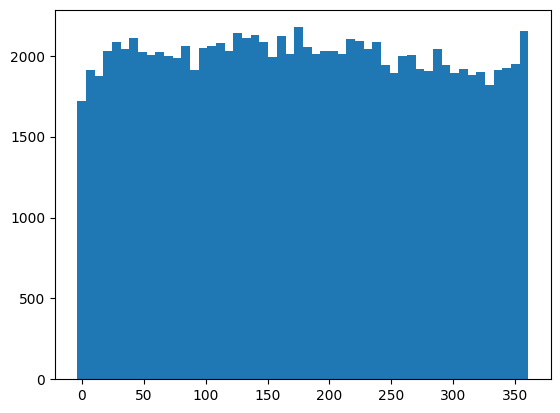

In [ ]:
L = []
for node in graph.nodes():
    for neigh in graph.successors(node):
        if neigh in node_dates and node in node_dates:
            d = days_between_dates(node_dates[neigh], node_dates[node])
            if d >= 0 and d <= 364:
                L.append(d)

n_bins = 52
counts, bins = np.histogram(L, bins=n_bins)

plt.bar(bins[:-1], counts, width=np.diff(bins))
plt.show()

In [ ]:
bins

array([  0.,   7.,  14.,  21.,  28.,  35.,  42.,  49.,  56.,  63.,  70.,
        77.,  84.,  91.,  98., 105., 112., 119., 126., 133., 140., 147.,
       154., 161., 168., 175., 182., 189., 196., 203., 210., 217., 224.,
       231., 238., 245., 252., 259., 266., 273., 280., 287., 294., 301.,
       308., 315., 322., 329., 336., 343., 350., 357., 364.])